In [2]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

with open("Systems Datas.json") as f:
    all_systems = json.load(f)

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


∫|w(t)|dt =  0.09848227384744018


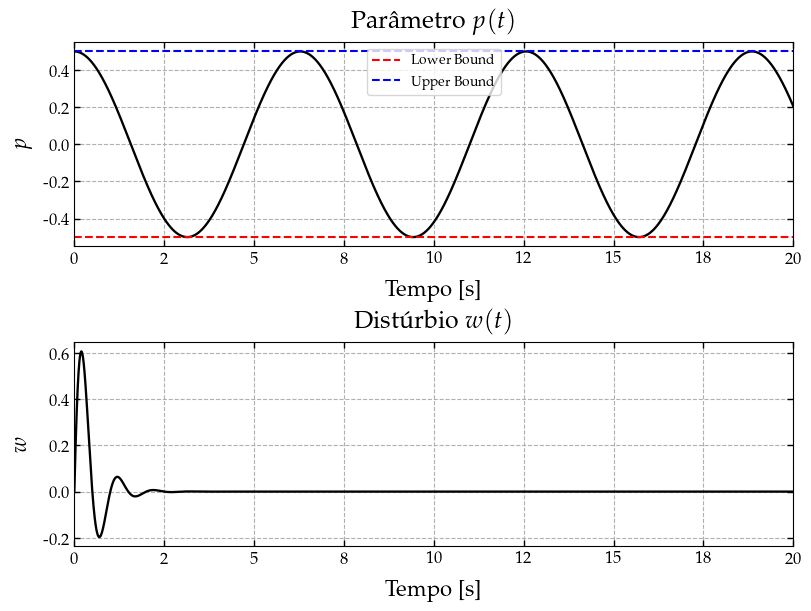

In [3]:
%matplotlib inline


simulation_step = 1e-4
simulation_time = 20
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

sys = nm.StateSpaceSystem("Systems Datas.json", "Abdullah2009",
                    simulation_time=simulation_time)
system_labels = sys.get_labels()

# === Verifica dependência de estados ===
def depends_on_states(expr: str, state_keys: list[str]) -> bool:
    return any(xi in expr for xi in state_keys)

# Extrai expressões de parâmetros e distúrbios
param_exprs = {k: v for k, v in sys.system_data.get("parameters", {}).items() if isinstance(v, str)}
dist_exprs = {k: v for k, v in sys.system_data.get("disturbances", {}).items() if isinstance(v, str)}


state_keys = system_labels.get("states", [])

param_deps = {k: depends_on_states(expr, state_keys) for k, expr in param_exprs.items()}
dist_deps = {k: depends_on_states(expr, state_keys) for k, expr in dist_exprs.items()}

# Se nenhuma expressão depende dos estados, gera os gráficos
if not any(param_deps.values()) and not any(dist_deps.values()):

  ρ_values = []
  w_values = []

  for t in timepts:
    p = sys.evaluate_parameters(t)  
    d = sys.evaluate_disturbances(t)
    ρ_values.append(p)
    w_values.append(d)


  ρ = np.array(ρ_values)
  w = np.array(w_values)

  integral_w_norm = np.sum(w**2) * (timepts[1] - timepts[0])
  print('∫|w(t)|dt = ', integral_w_norm)

  # === Gráficos ===
  cfg = {
    'style': { 'color': 'black', },
    'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
              'x_label_fontsize': 16,
              'y_label_fontsize': 16,
              'tick_fontsize': 18,},
    'limits': { 'x_min': 0., 'x_max': simulation_time * 1e3,}
  }

  mosaic = [[key] for key in system_labels['parameters']]
  mosaic += [[key] for key in system_labels['disturbances']]

  fig = plt.figure(figsize=(8, len(mosaic) * 3), layout='constrained')
  axs = fig.subplot_mosaic(mosaic)

  t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
      timepts, 's', use_prefixes=True, n_divs=5
  )
  axis_limits = {'x_min': 0., 'x_max': t_formatted[-1]}

  rho_bounds = sys.system_data.get("bounds", {}).get("ρ", {})

  for idx, (section, source, values) in enumerate([
      ("parameters", system_labels['parameters'], ρ),
      ("disturbances", system_labels['disturbances'], w)
  ]):
    for i, (key, label_data) in enumerate(source.items()):
      series = [v[i] if section == "parameters" else v[0] for v in values]
      y_formatted, y_unit_label, y_decimal_places = nm.format_magnitudes(
          series, unit=label_data['unit'], use_prefixes=True, n_divs=5
      )

      ax = axs[key]

      gph.plot(
        axs[key], t_formatted, y_formatted, title=label_data['name'],
        xlabel='Tempo' + t_unit_label,
        ylabel=label_data['symbol'] + y_unit_label, label='',
        plot_cfg={**cfg,
          'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                    'y_digits': y_decimal_places},
          'limits': { **cfg['limits'], **axis_limits },
        }
      )

      # Adiciona barras horizontais só para parâmetros (section == "parameters")
      if section == "parameters":
        # Os limites são obtidos pelo índice '1' do seu JSON
        bounds = rho_bounds.get(f'{i+1}', None)
        if bounds:
            ymin, ymax = bounds
            ax.axhline(y=ymin, color='red', linestyle='--', linewidth=1.5, label='Lower Bound')
            ax.axhline(y=ymax, color='blue', linestyle='--', linewidth=1.5, label='Upper Bound')

        # Adiciona legenda para as linhas de limite (opcional)
        ax.legend()
else:
    print("Parâmetros dependem dos estados — gráficos não serão gerados antes da simulação.")


In [4]:
import numpy as np


def get_C(p):
  return np.array([[0., 1.]])


def plant_dynamics(t, x, inputs, sys: nm.StateSpaceSystem):
  nu, nρ, nw = sys.nu, sys.nρ, sys.nw
  labels = sys.get_labels()

  u = inputs[0:nu].reshape(-1, 1)
  ρ = inputs[nu:nu + nρ]
  w = inputs[nu + nρ:nu + nρ + nw].reshape(-1, 1)

  state_dict = {k: float(v) for k, v in zip(
      labels.get("states", []), x.flatten())}
  param_dict = dict(zip(labels.get("parameters", []), ρ))
  disturb_dict = dict(zip(labels.get("disturbances", []), w.flatten()))

  matrices = sys.evaluate_matrices(state_dict, param_dict, disturb_dict)
  return matrices["A"] @ x + matrices["B"] @ u + matrices["E"] @ w


def plant_output(t, x, u, params):
  return x

## Simulação da Planta em Malha Aberta

In [5]:
def openloop_simulation(x0, T_s, sys: nm.StateSpaceSystem, u, timepts):
  N = len(timepts)
  nx = x0.shape[0]
  x = np.zeros((nx, N + 1, 1))
  x[:, 0, :] = x0
  y = []
  state_labels = sys.get_labels()["states"]

  for k, t in enumerate(timepts):
    state_k = x[:, k, :].flatten()
    state_dict = dict(zip(state_labels, state_k))

    ρ = sys.evaluate_parameters(t, state_dict)
    w = sys.evaluate_disturbances(t, state_dict)

    u_col = u[k].reshape(-1, 1)
    ρ_vec = np.array(sys.evaluate_parameters(t)).reshape(1, -1)
    w_vec = np.array(sys.evaluate_disturbances(t)).reshape(-1, 1)
    inputs_vec = np.hstack((u_col, ρ_vec, w_vec))[0]

    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          lambda t_, x_, inputs_, p: plant_dynamics(
              t_, x_, inputs_, sys),
          t,
          x[:, k, :],
          inputs_vec,
          T_s,
          ρ
      )

  return y

In [6]:
n_u = len(sys.get_labels()['inputs'])
u = np.zeros((len(timepts), n_u, 1))

x0 = np.array([[1.0], [-1.0]])
y = openloop_simulation(x0, simulation_step, sys, u, timepts)

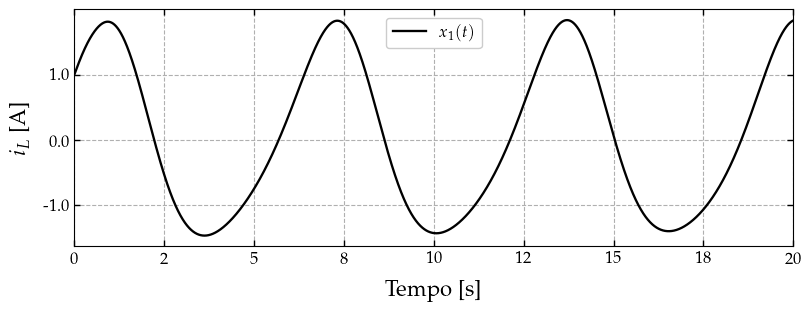

In [7]:
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

x_norm = np.array([np.linalg.norm(y_k) for y_k in y])

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)
x1_formatted, x1_unit_label, x1_decimal_places = nm.format_magnitudes([
    v[0] for v in y], unit='A', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': t_formatted[-1]}

gph.plot(
    axs['x'], t_formatted,
    x1_formatted,
    xlabel='Tempo' + t_unit_label,
    ylabel='$i_L$' + x1_unit_label, label='$x_1(t)$',
    plot_cfg={
        **cfg,
        'axis': {**cfg['axis'], 'x_digits': t_decimal_places, 'y_digits': x1_decimal_places},
        'limits': {**cfg['limits'], **axis_limits},
    }
)

In [8]:
def solve_problem(
    h: float,
    υ: float,
    δ: float,
    ε_γ: float,
    ρ_bar,
    λ: Optional[float] = None,
    θ: Optional[float] = None,
    eps: float = 1e-6,
):
  n_u = sys.nu
  n_p = sys.nρ
  n_x = sys.nx
  n_w = sys.nw
  n_z = 1

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))

  Aρ, Aϱ = {}, {}
  Bρ, Bϱ = {}, {}
  Eρ, Eϱ = {}, {}

  C = {}

  ρ_bounds = sys.get_rho_bounds()
  φ_bounds = np.array([[-.25, .25]])
  u_bar = sys.get_u_bar()

  ϱ_bounds = []
  for i in range(n_p):
    ϱ_bounds += [ρ_bar[i] + h * φ_bounds[i]]

  for i in Bnp:
    labels = sys.get_labels()
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    ϱi = [ϱ_bounds[idx][i[idx]] for idx in range(n_p)]

    param_dict_ϱ = dict(zip(labels.get("parameters", []), ϱi))
    param_dict_ρ = dict(zip(labels.get("parameters", []), ρi))

    matrices_ϱ = sys.evaluate_matrices(None, param_dict_ϱ, None)
    matrices_ρ = sys.evaluate_matrices(None, param_dict_ρ, None)

    Aϱ[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=matrices_ϱ['A'])
    Aρ[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=matrices_ρ['A'])

    Bϱ[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=matrices_ϱ['B'])
    Bρ[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=matrices_ρ['B'])

    Eϱ[i] = cp.Parameter((n_x, n_w), name=f'E[{i}]', value=matrices_ϱ['E'])
    Eρ[i] = cp.Parameter((n_x, n_w), name=f'E[{i}]', value=matrices_ρ['E'])

    C[i] = cp.Parameter((n_z, n_x), name=f'C[{i}]', value=get_C(ρi))

  e = nm.get_e(5 * [n_x] + [1, n_u, n_w])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + n_u, 2 * n_x + n_u), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_u))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_u))
  S4til = cp.Variable((n_x, n_x))

  Ktil = {}
  L1til = {}
  L2til = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    L1til[i] = cp.Variable((n_u, n_x), name=f'L1[{i}]')
    L2til[i] = cp.Variable((n_u, n_x), name=f'L2[{i}]')
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> eps * np.eye(ℵ[i].shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  λ = cp.Parameter(value=λ)
  γ = cp.Variable(pos=True)
  δ = cp.Parameter(value=δ)
  β = cp.Variable(pos=True)
  θtil = cp.Parameter(value=(1. / θ))

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[7]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Λ(i, j, k):
    Bscr = Aρ[i] @ X @ e[1] + Bρ[i] @ Ktil[j] @ e[2] - \
        X @ e[4] + Bρ[i] @ Ktil[j] @ e[5] - \
        Bρ[i] @ ℵ[j] @ e[7] + γ * Eρ[i] @ e[8]

    Bscr += Aϱ[k] @ X @ e[1] + Bϱ[k] @ Ktil[j] @ e[2] + \
        Bϱ[k] @ Ktil[j] @ e[5] - Bϱ[k] @ ℵ[j] @ e[7] + γ * Eϱ[k] @ e[8]

    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[7] + S4til @ e[5]))

    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[7] + Q4til @ e[5]))

    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] +
                         Q3til @ e[7] + Q4til @ e[5]))

    Θ4 = nm.He(e[4].T @ (S1til @ (e[1] - e[2]) + S2til @
               e[2] + S3til @ e[7] + S4til @ e[5])) + \
        e[4].T @ Rtil @ e[4]

    Θ5 = e[7].T @ (ℵ[j] @ e[7] - L1til[j] @ e[2] - L2til[j] @ e[5])

    Θtil = {}
    Θtil['0'] = -λ * e[6].T @ e[6] - e[5].T @ Ξtil @ e[5] - Θ1 - \
        h * e[3].T @ Q1til @ e[3] + h * Θ3 - γ * e[8].T @ e[8] + \
        h * κ1.T @ Mtil @ κ1 + h * e[4].T @ Rtil @ e[4] - Θ5 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil) + \
        h * Θ4

    Θtil['h'] = - λ * e[6].T @ e[6] - e[5].T @ Ξtil @ e[5] - Θ1 - \
        h * Θ2 - h * e[3].T @ Q1til @ e[3] - γ * e[8].T @ e[8] - \
        h * κ1.T @ Mtil @ κ1 - Θ5 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil)

    Γ1_11 = Θtil['0']
    Γ1_12 = e[2].T @ X.T
    Γ1_13 = e[1].T @ X.T @ C[i].T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Ψtil
    Γ1_23 = np.zeros((n_x, n_z))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - np.eye(n_z)

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13],
                  [Γ1_21, Γ1_22, Γ1_23],
                  [Γ1_31, Γ1_32, Γ1_33]])

    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T
    Γ2_13 = e[2].T @ X.T
    Γ2_14 = e[1].T @ X.T @ C[i].T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))
    Γ2_24 = np.zeros((2 * n_x, n_z))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil
    Γ2_34 = np.zeros((n_x, n_z))

    Γ2_41 = Γ2_14.T
    Γ2_42 = Γ2_24.T
    Γ2_43 = Γ2_34.T
    Γ2_44 = - np.eye(n_z)

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_14],
                  [Γ2_21, Γ2_22, Γ2_23, Γ2_24],
                  [Γ2_31, Γ2_32, Γ2_33, Γ2_34],
                  [Γ2_41, Γ2_42, Γ2_43, Γ2_44]])

    return Γ1, Γ2

  binary_pairs = nm.binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_SUM = {}
    LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

    for k in Bnp:
      for pair in pairs:
        Λ = {}
        Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1], k)
        LMI_SUM['0'] += Λ['0']
        LMI_SUM['h'] += Λ['h']

    constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
    constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['h'].shape[0])]

  for ell in range(n_u):
    for j in Bnp:
      LMISAT11 = Ptil
      LMISAT12 = np.zeros((n_x, n_x))
      LMISAT13 = np.zeros((n_x, 1))
      LMISAT14 = (Ktil[j][ell:ell+1] - L1til[j][ell:ell+1]).T
      LMISAT15 = (Ktil[j][ell:ell+1] - L1til[j][ell:ell+1]).T
      LMISAT16 = X.T

      LMISAT21 = LMISAT12.T
      LMISAT22 = Ξtil
      LMISAT23 = np.zeros((n_x, 1))
      LMISAT24 = (Ktil[j][ell:ell+1] - L2til[j][ell:ell+1]).T
      LMISAT25 = (Ktil[j][ell:ell+1] - L2til[j][ell:ell+1]).T
      LMISAT26 = np.zeros((n_x, n_x))

      LMISAT31 = LMISAT13.T
      LMISAT32 = LMISAT23.T
      LMISAT33 = (1. - θtil) * np.eye(1)
      LMISAT34 = np.zeros((1, 1))
      LMISAT35 = np.zeros((1, 1))
      LMISAT36 = np.zeros((1, n_x))

      LMISAT41 = LMISAT14.T
      LMISAT42 = LMISAT24.T
      LMISAT43 = LMISAT34.T
      LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)
      LMISAT45 = np.zeros((1, 1))
      LMISAT46 = np.zeros((1, n_x))

      LMISAT51 = LMISAT15.T
      LMISAT52 = LMISAT25.T
      LMISAT53 = LMISAT35.T
      LMISAT54 = np.zeros((1, 1))
      LMISAT55 = γ * δ * (u_bar[ell] ** 2) * np.eye(1)
      LMISAT56 = np.zeros((1, n_x))

      LMISAT61 = LMISAT16.T
      LMISAT62 = LMISAT26.T
      LMISAT63 = LMISAT36.T
      LMISAT64 = LMISAT46.T
      LMISAT65 = LMISAT56.T
      LMISAT66 = Ψtil

      LMISAT = cp.bmat(
          [[LMISAT11, LMISAT12, LMISAT13, LMISAT14, LMISAT15, LMISAT16],
           [LMISAT21, LMISAT22, LMISAT23, LMISAT24, LMISAT25, LMISAT26],
           [LMISAT31, LMISAT32, LMISAT33, LMISAT34, LMISAT35, LMISAT36],
           [LMISAT41, LMISAT42, LMISAT43, LMISAT44, LMISAT45, LMISAT46],
           [LMISAT51, LMISAT52, LMISAT53, LMISAT54, LMISAT55, LMISAT56],
           [LMISAT61, LMISAT62, LMISAT63, LMISAT64, LMISAT65, LMISAT66]])

      constraints += [LMISAT >> 0]

  LMID0_11 = β * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  constraints += [LMID0 >> 0]

  constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Ξtil >> eps * np.eye(n_x)]
  constraints += [γ >= ε_γ]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  # prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv

    error = False

    if error == False:
      K = {}
      L1 = {}
      L2 = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        L1[i] = L1til[i].value @ Xinv
        L2[i] = L2til[i].value @ Xinv

      etm_results = {'Ξ': Ξ, 'Ψ': Ψ, 'θ': (1. / θtil.value), 'λ': λ.value}
      design_results = {
          'optimal_value': prob.value,
          'etm': etm_results,
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          'lyapunov': [P, S2],
          'bounds': [γ.value, β.value]
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [9]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
Θ, λ = None, None
optimal_value = None
δinv = 1e-1
ρ_bar = [0.15]


# Parâmetros e resolução do problema
h, υ, ε_γ, δ, λ = 1e-2, 1e-4, 1e-1, 1. / δinv, 1e-1
θ = (1. / λ) * (np.exp(λ * h) - 1) + 1
prob_res = solve_problem(h=h, υ=υ, δ=δ, ε_γ=ε_γ, λ=λ,
                         θ=θ, ρ_bar=ρ_bar, eps=1e-12)

if prob_res is not None:
  Ξ, Ψ = prob_res['etm']['Ξ'], prob_res['etm']['Ψ']
  θ, λ = prob_res['etm']['θ'], prob_res['etm']['λ']
  K, L1, L2 = prob_res['controller']['K'], prob_res['controller']['L1'], \
      prob_res['controller']['L2']
  P, S2 = prob_res['lyapunov']
  γ, β = prob_res['bounds']
  optimal_value = prob_res['optimal_value']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= {1./β:.3e}')
  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')
  print(f'γ = {γ:.3e}')
  print(f'Induced gain = {(np.sqrt(1. / γ)):.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))

  display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in nm.binary_set(sys.nρ):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

θ = 1.010e+00
λ = 1.000e-01
γ = 1.000e-01
Induced gain = 3.162e+00


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
eps_γ_values = np.logspace(-6, -1, num=1000)

# Função a ser executada em paralelo


def run_solver(eps_γ):
  try:
    prob_res = solve_problem(h=h, υ=υ, δ=δ, ε_γ=eps_γ,
                             λ=λ, θ=θ, ρ_bar=ρ_bar, eps=1e-5)
    if prob_res is not None:
      γ, β = prob_res['bounds']
      optimal_value = prob_res['optimal_value'] - β
      return γ, β, optimal_value
  except Exception as e:
    print(f'Erro para ε_γ = {eps_γ:.1e}: {e}')
  return None


# Execução paralela com processos
results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
  futures = {executor.submit(run_solver, eps): eps for eps in eps_γ_values}
  for future in concurrent.futures.as_completed(futures):
    result = future.result()
    if result is not None:
      results.append(result)

# Organiza os resultados por γ
results = sorted(results, key=lambda x: x[0])
γ_vals = np.array([r[0] for r in results])
β_vals = np.array([r[1] for r in results])
traces = np.array([r[2] for r in results])

Erro para ε_γ = 1.0e-01: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.
Erro para ε_γ = 9.9e-02: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.


In [11]:
data_to_save = {
    "gamma_vals": γ_vals.tolist(),
    "traces": traces.tolist(),
    "beta_vals": β_vals.tolist()
}

# Salva em arquivo JSON
with open("Results/Notebook-V/ClosedLoop_Results_OptProb.json", "w") as f:
  json.dump(data_to_save, f, indent=2)

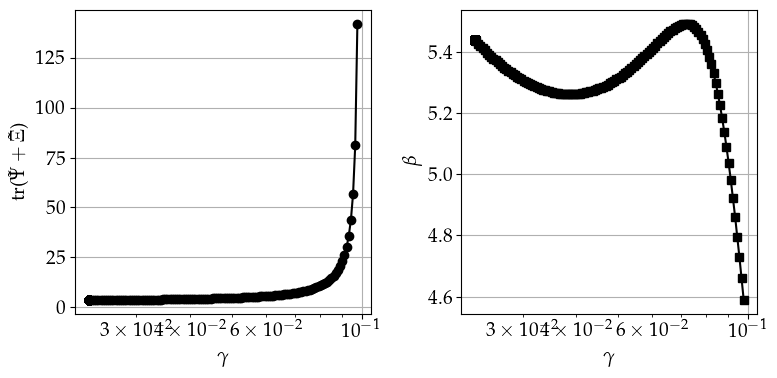

In [12]:
%matplotlib inline

# Define configurações globais de fonte
plt.rcParams.update({
    'font.size': 14,       # Tamanho de fonte global
    'axes.labelsize': 14,  # Tamanho dos rótulos dos eixos
    'xtick.labelsize': 14,  # Tamanho dos ticks no eixo x
    'ytick.labelsize': 14,  # Tamanho dos ticks no eixo y
})

# Layout lado a lado
mosaic = [['tr', 'β']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 4))

# Gráfico 1: tr(Ψ + Ξ) vs γ
axs['tr'].plot(γ_vals, traces, marker='o', color='black')
axs['tr'].set_xscale('log')
axs['tr'].set_xlabel(r'$\gamma$')
axs['tr'].set_ylabel(r'tr($\tilde \Psi + \tilde \Xi$)')
axs['tr'].grid(True)

# Gráfico 2: β vs γ
axs['β'].plot(γ_vals, β_vals, marker='s', color='black')
axs['β'].set_xscale('log')
axs['β'].set_xlabel(r'$\gamma$')
axs['β'].set_ylabel(r'$\beta$')
axs['β'].grid(True)

# Ajuste final e exibição
plt.tight_layout()
plt.show()

In [22]:
# Definindo intervalo de plotagem
x1_range = (-1.0, 1.0)
x2_range = (-1.0, 1.0)
num_points = 20

/tmp/ipykernel_38581/19297566.py:29: UserWarning: linewidths is ignored by contourf
  ax.contourf(X, Y, saturation_region, levels=[0.4, 1.5], colors=['#d0d0d0'], linewidths=0)


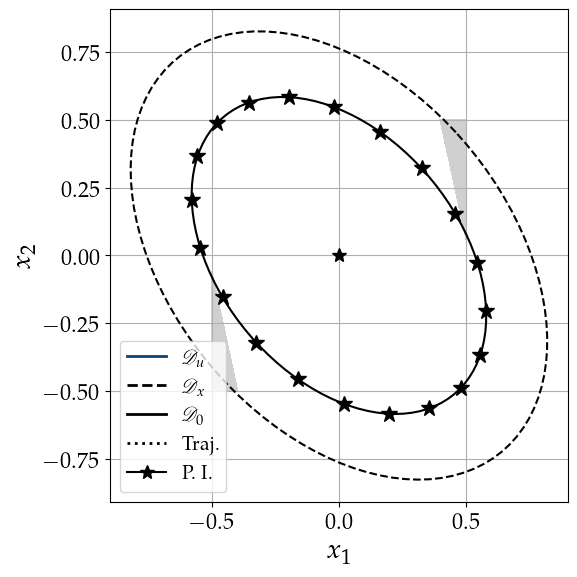

In [14]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# a_q = nm.get_vertices(x_bounds)

B2 = nm.binary_set(sys.nρ)
u_bar = sys.get_u_bar()

x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))


X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T
Du_region = np.ones(X.shape, dtype=bool)
for b in B2:
  result = np.abs(points @ (K[b] - L1[b]).T)
  # result = np.abs(points @ (K[b]).T)
  Du_region &= (result.reshape(X.shape) <= u_bar[0])
ax.contour(X, Y, Du_region, colors='#084475', linewidths=1.5)

Du_tilde_region = np.ones(X.shape, dtype=bool)
for b in B2:
    result = np.abs(points @ (K[b]).T)
    Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
saturation_region = ~Du_tilde_region

ax.contourf(X, Y, saturation_region, levels=[0.4, 1.5], colors=['#d0d0d0'], linewidths=0)

X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)
X0_list = np.hstack((np.array([[-0.20346692],  [0.33822176]]), X0_list))

D0 = nm.get_ellipsoid_boundary(P, 1)
plt.plot(D0['x1_vals'], D0['x2_vals'], 
         'k-', label='')

μ_inv = 1. + (1. / (γ * δ))
Dx = nm.get_ellipsoid_boundary(P, μ_inv)
plt.plot(Dx['x1_vals'], Dx['x2_vals'], 
         'k--', label='')

# Ajustes finais de layout
ax.set_xlabel("$x_1$", fontsize=20)
ax.set_ylabel("$x_2$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

ax.grid(True)

# Legendas
elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
    ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = [r'$\mathscr{D}_u$', r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', 
          'Traj.', 'P. I.']

gph.create_custom_legend(ax, elements, labels)

# Exibir o gráfico
plt.tight_layout()

In [15]:
def closedloop_simulation(x0, η0, λ, θ, T_s):

  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1))
  η = np.zeros((N + 1, 1))

  x[:, 0, :] = x0
  η[0, :] = η0

  xτ = x0.copy()

  y = []
  uc = []
  ρ_hat_list = []

  ρ_hat = np.array(sys.evaluate_parameters(0)).reshape(-1, 1)
  x_hat = x0
  event_times = [0.]
  trigger_async = [False]

  next_time_sampling = h

  def triggering_condition(η, x, ε, ρ):
    Tcal = x.T @ Ψ @ x - ε.T @ Ξ @ ε
    if η <= 1e-4:
      η = 0
    new_event = η + θ * Tcal[0][0] < -1e-4
    triggering_by_async = False
    if not new_event:
      for i in range(1):
        new_event = np.abs(ρ[i] - ρ_hat[i]) > ρ_bar[i]
        if new_event:
          triggering_by_async = True
          break
    return new_event, triggering_by_async

  def etm_dynamics(t, η, u, params):
    ε = x_hat - xτ
    Tcal = xτ.T @ Ψ @ xτ - ε.T @ Ξ @ ε
    η_dot = - λ * η + Tcal[0][0]
    return η_dot

  def control_signal():
    ρ_bounds = sys.get_rho_bounds()
    u_bar = sys.get_u_bar()
    α0 = (ρ_bounds[0][1] - ρ_hat) / (ρ_bounds[0][1] - ρ_bounds[0][0])
    uc_k = α0 * K[(0,)] @ x_hat + (1. - α0) * K[(1,)] @ x_hat
    return np.array([[sgn.sat(uc_k[0, 0], u_bar[0])]])

  for k, t in enumerate(timepts):

    ρ = np.array(sys.evaluate_parameters(t)).reshape(-1, 1)
    w = np.array(sys.evaluate_disturbances(t)).reshape(-1, 1)

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :]
      ε = x_hat - xτ
      new_event, triggering_by_async = triggering_condition(η[k], xτ, ε, ρ)
      if new_event:
        # print('True')
        ρ_hat = ρ
        x_hat = xτ
        event_times.append(t)
        trigger_async.append(triggering_by_async)

    # Cálculo do sinal de controle
    u_sat = control_signal()
    inputs_vec = np.hstack((u_sat, ρ, w))[0]

    # Saída da planta
    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    # Atualização dos estados para o próximo passo (k+1)
    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          lambda t_, x_, inputs_, p: plant_dynamics(t_, x_, inputs_, sys),
          t, x[:, k, :], inputs_vec, T_s, ρ)
      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :], None, T_s, None)

    # Armazena controle e saída em k
    uc.append(u_sat)
    ρ_hat_list.append(ρ_hat)

  return y, uc, η[:N], event_times, trigger_async, ρ_hat_list

In [19]:
# Nome do arquivo de experimento
experiment_name = "Results/Notebook-V/ClosedLoop_Results_Abdullah2009.json"
force_simulation = True
simulations_amount = 21

# Estrutura para armazenar os resultadosevent_times
results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'eta': [],
    'trigger_async': [],
    'ρ_hat_list': [],
}

# Função para converter arrays e listas aninhadas em estruturas serializáveis


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj

# Função para converter de volta para arrays


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }


# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  def get_trajectories(i):
    x0 = np.array([[X0_list[0][i]], [X0_list[1][i]]])
    η0 = np.array([[0.]])

    y, uc, η, event_times, trigger_async, ρ_hat_list = closedloop_simulation(
        x0, η0, λ, θ, T_s=simulation_step)
    inter_event_times = np.diff(event_times).tolist()

    return {
        'trajectories': y,
        'eta': η,
        'control-signal': uc,
        'inter-event-times': inter_event_times,
        'trigger_async': trigger_async,
        'ρ_hat_list': ρ_hat_list
    }

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['eta'].append(res['eta'])
    results_clsim['trigger_async'].append(res['trigger_async'])
    results_clsim['ρ_hat_list'].append(res['ρ_hat_list'])

  # Serializar e salvar
  results_serializable = convert_to_serializable(results_clsim)

  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Simulações concluídas. Resultados salvos em Results/Notebook-V/ClosedLoop_Results_Abdullah2009.json.


In [27]:
%matplotlib qt

simulation_index = 0
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
η = results_clsim['eta'][simulation_index]
trigger_async = results_clsim['trigger_async'][simulation_index][1:]
event_times = np.cumsum(inter_event_times)

mosaic = [['η'], ['sat'], ['x'], ['iet']]    
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 12))

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': t_formatted[-1]}

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))

if len(inter_event_times) != 0:
  print("Menor IET Obtido: ", min(inter_event_times))
  print("Máximo IET Obtido: ", max(inter_event_times))
  print(f"Média do Intervalos de Tempo entre Eventos: {np.mean(inter_event_times):.3f}" )


n_f, n_ul, n_dp = nm.format_magnitudes(
    η, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['η'], t_formatted, n_f,
    xlabel='t [s]', ylabel='$\\eta(t)\\,$' + n_ul,
    # title='Variável dinâmica do ETM',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': n_dp},
        'limits': { **cfg['limits'], **axis_limits },
      })


axs['sat'].hlines([u_bar[0] * 1e1, -u_bar[0] * 1e1], 
                  0, t_formatted[-1], colors='black', linestyles='--', label='$\\pm \\bar u$', linewidths=2.)
axs['sat'].legend(prop={'size': 16})


# Plot sinal de saída
gph.plot(
    axs['x'], t_formatted, [v[0] * 1e1 for v in y],
    xlabel='t [s]', label='$x_1$', plot_cfg={**cfg,
        'style': {**cfg['style'], 'linestyle': '--'},})

gph.plot(
    axs['x'], t_formatted, [v[1] * 1e1 for v in y],
    xlabel='t [s]', ylabel=r'$x$ $[\times 10^{-1}]$',
    # title='Estados da Planta - $x(t)$', 
    label='$x_2$',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': 1},
        'limits': { **cfg['limits'], **axis_limits },
        'legend': {'fontsize': 16}
      })

gph.plot(
    axs['sat'], t_formatted,
    [float(v[0, 0]) * 1e1 for v in uc],
    xlabel='t [s]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-1}$]',
    # title='Sinal de Controle Saturado (sat($u(t)$))', 
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': 0},
        'limits': { **cfg['limits'], **axis_limits },
        'legend': {'fontsize': 16}
      })


# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = cfg.copy()
    stem_cfg['axis']['y_digits'] = 0

    # Convertendo para milissegundos
    iet_ms = [et for et in inter_event_times]

    # Separando índices conforme o vetor booleano
    false_indexes = [i for i, val in enumerate(trigger_async) if not val]
    true_indexes = [i for i, val in enumerate(trigger_async) if val]

    # Eventos e tempos separados
    event_times_false = [event_times[i] for i in false_indexes]
    # print(iet_ms)
    iet_false = [iet_ms[i] for i in false_indexes]


    event_times_true = [event_times[i] for i in true_indexes]
    iet_true = [iet_ms[i] for i in true_indexes]

    # Plotando barras com cor azul para False
    if len(event_times_false) > 0:
      gph.stem(
          axs['iet'], event_times_false, iet_false,
          stem_cfg={**stem_cfg, 
                    'limits': { **cfg['limits'], **axis_limits },
                    'style': {'color': '#000'}},
          xlabel='t [s]', ylabel='$t_{k+1} - t_k$ [$s$]',
          title='',
      )

    # Plotando barras com cor vermelha para True
    if len(event_times_true) > 0:
      gph.stem(
          axs['iet'], event_times_true, iet_true,
          stem_cfg={**stem_cfg, 
                    'limits': { **cfg['limits'], **axis_limits },
                    'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': 1},
                    'style': {'color': '#950101'}}
      )

else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('Time [s]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, simulation_time])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=2.)

Estado Inicial:  [-0.20346692  0.33822176]
Número de Eventos Acionados:  78
Menor IET Obtido:  0.04
Máximo IET Obtido:  1.4900000000000002
Média do Intervalos de Tempo entre Eventos: 0.254


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [25]:
%matplotlib qt

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# a_q = nm.get_vertices(x_bounds)

B2 = nm.binary_set(sys.nρ)
u_bar = sys.get_u_bar()

X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))

# Du_tilde_region = np.ones(X.shape, dtype=bool)
# for b in B2:
#     result = np.abs(points @ (K[b]).T)
#     Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
# ax.contourf(X, Y, Du_tilde_region, levels=[0.4, 1.5], colors=['#f2f2f2'], linewidths=0)

Du_tilde_region = np.ones(X.shape, dtype=bool)
for b in B2:
    result = np.abs(points @ (K[b]).T)
    Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
saturation_region = ~Du_tilde_region

ax.contourf(X, Y, saturation_region, levels=[0.4, 1.5], colors=['#e4e4e4'], linewidths=0)



Du_region = np.ones(X.shape, dtype=bool)
for b in B2:
  result = np.abs(points @ (K[b] - L1[b]).T)
  # result = np.abs(points @ (K[b]).T)
  Du_region &= (result.reshape(X.shape) <= u_bar[0])
ax.contour(X, Y, Du_region, colors='#084475', linewidths=1.5)

X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)

D0 = nm.get_ellipsoid_boundary(P, 1)
plt.plot(D0['x1_vals'], D0['x2_vals'], 
         'k-', label='')

μ_inv = 1. + (1. / (γ * δ))
Dx = nm.get_ellipsoid_boundary(P, μ_inv)
plt.plot(Dx['x1_vals'], Dx['x2_vals'], 
         'k--', label='')

# Apresentação das trajetórias dos estados 
trajectories = results_clsim['trajectories']
for y in trajectories:
  ax.plot([v[0] for v in y], [v[1] for v in y], 
          color='black', linestyle=':')


# Ajustes finais de layout
ax.set_xlabel("$x_1$", fontsize=20)
ax.set_ylabel("$x_2$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

ax.grid(True)
# ax.set_xticks(np.linspace(x1_range[0], x1_range[1], 5))
# ax.set_yticks(np.linspace(x2_range[0], x2_range[1], 5))


# Legendas
elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
    ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    # ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = [r'$\mathscr{D}_u$', r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', 
          'Trajetórias']
gph.create_custom_legend(ax, elements, labels)

# Exibir o gráfico
plt.tight_layout()

/tmp/ipykernel_38581/821597473.py:28: UserWarning: linewidths is ignored by contourf
  ax.contourf(X, Y, saturation_region, levels=[0.4, 1.5], colors=['#e4e4e4'], linewidths=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
